# Intermediate Machine Learning: Assignment 3

**Deadline**

Assignment 3 is due Wednesday, November 1 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Variational autoencoders
 * Undirected graphs
 * The graphical lasso

This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: Face time (35 points)

In this problem, we will implement a "shoestring" version of [this amazing fake face generator](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html), using a variational autoencoder (VAE). Building a generator like the one featured in the article can take a tremendous amount of computational resources, time, and parameter tuning. In this problem we will build a basic version to illustrate the main concepts, and help you to become more famililar with VAEs.  Here is an outline of the process that we'll step you through:

### Problem outline:

* Load data
* Create face groups based on attributes
* Construct the VAE
* Define the loss function and train the VAE (Problem 1.1)
* Encode and reconstruct faces (Problem 1.2)
* Visualize the latent space (Problem 1.3)
* Morph between faces (Problem 1.4)
* Shift attributes of faces (Problem 1.5)
* Generate new faces (Problem 1.6)
* Analyze the effect of the scaling factor in the loss function (Problem 1.7, optional)

In the next cell we load the packages that we'll need. If you don't have one or more of these, you can install them with `!pip install <package_name>` in the cell, or outside the notebook
with `conda install -c conda-forge <package_name>`

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
# tensorflow.compat.v1.disable_eager_execution()

### Loading the data

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) is a database of face photographs. The images are placed in the folder lfw-deepfunneled. lfw_attributes.txt is a document including a set of attributes associated for each image, such as 'Male', 'Smile', 'Bold', etc. All the features are numerical and large positive values indicate that the keywords well describe the photo; large negative values indicate that the keywords don't fit the photo.

For this problem, we will keep only the middle parts of the photos to avoid complex backgrounds.

Download the data from the cloud at these URLs:

https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
<br>
https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

Once you have the data, unzip it, and place it in a directory that we will call "YOUR_PATH" below.
  
Run all the cells in this section to load the data.

Note: Please write down the entire path instead of using something like '~/Desktop/datasets/' to avoid unnecessary compiling errors. Also, if you choose to use Colab to do your homework. We need to download the data into the same directory as your code. You may also need

"from google.colab import drive"

"drive.mount('/content/drive')"

to enable using paths in Google Drive before starting your code below. But personally, I would suggest using jupyter notebook to run the code locally instead of using Google Colab since the latter may take longer time.

In [2]:
# Change these path names to correspond with your directory
# DATASET_PATH ="/YOUR_PATH/lfw-deepfunneled/"
# ATTRIBUTES_PATH = "/YOUR_PATH/lfw_attributes.txt"

DATASET_PATH ="lfw-deepfunneled"
ATTRIBUTES_PATH = "lfw_attributes.txt"

# Change these path names to correspond with your directory
DATASET_PATH ="/Users/zeyiwang/Documents/GitHub/SDS665/assignment/assn3/problem1/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/Users/zeyiwang/Documents/GitHub/SDS665/assignment/assn3/problem1/lfw_attributes.txt"

In [3]:
# Make sure the above path is correct before running this cell
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100 )
dataset.head(10)

person                                               path
0      German_Khan  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
1  Stefano_Gabbana  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
2     Dragan_Covic  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
3    Jeff_Hornacek  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
4    Sureyya_Ayhan  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
5       Deb_Santos  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
6      Bob_Newhart  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
7      Wang_Hailan  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
8     Paul_McNulty  /Users/zeyiwang/Documents/GitHub/SDS665/assign...
9     Paul_McNulty  /Users/zeyiwang/Documents/GitHub/SDS665/assign...

The following cell will display some sample images

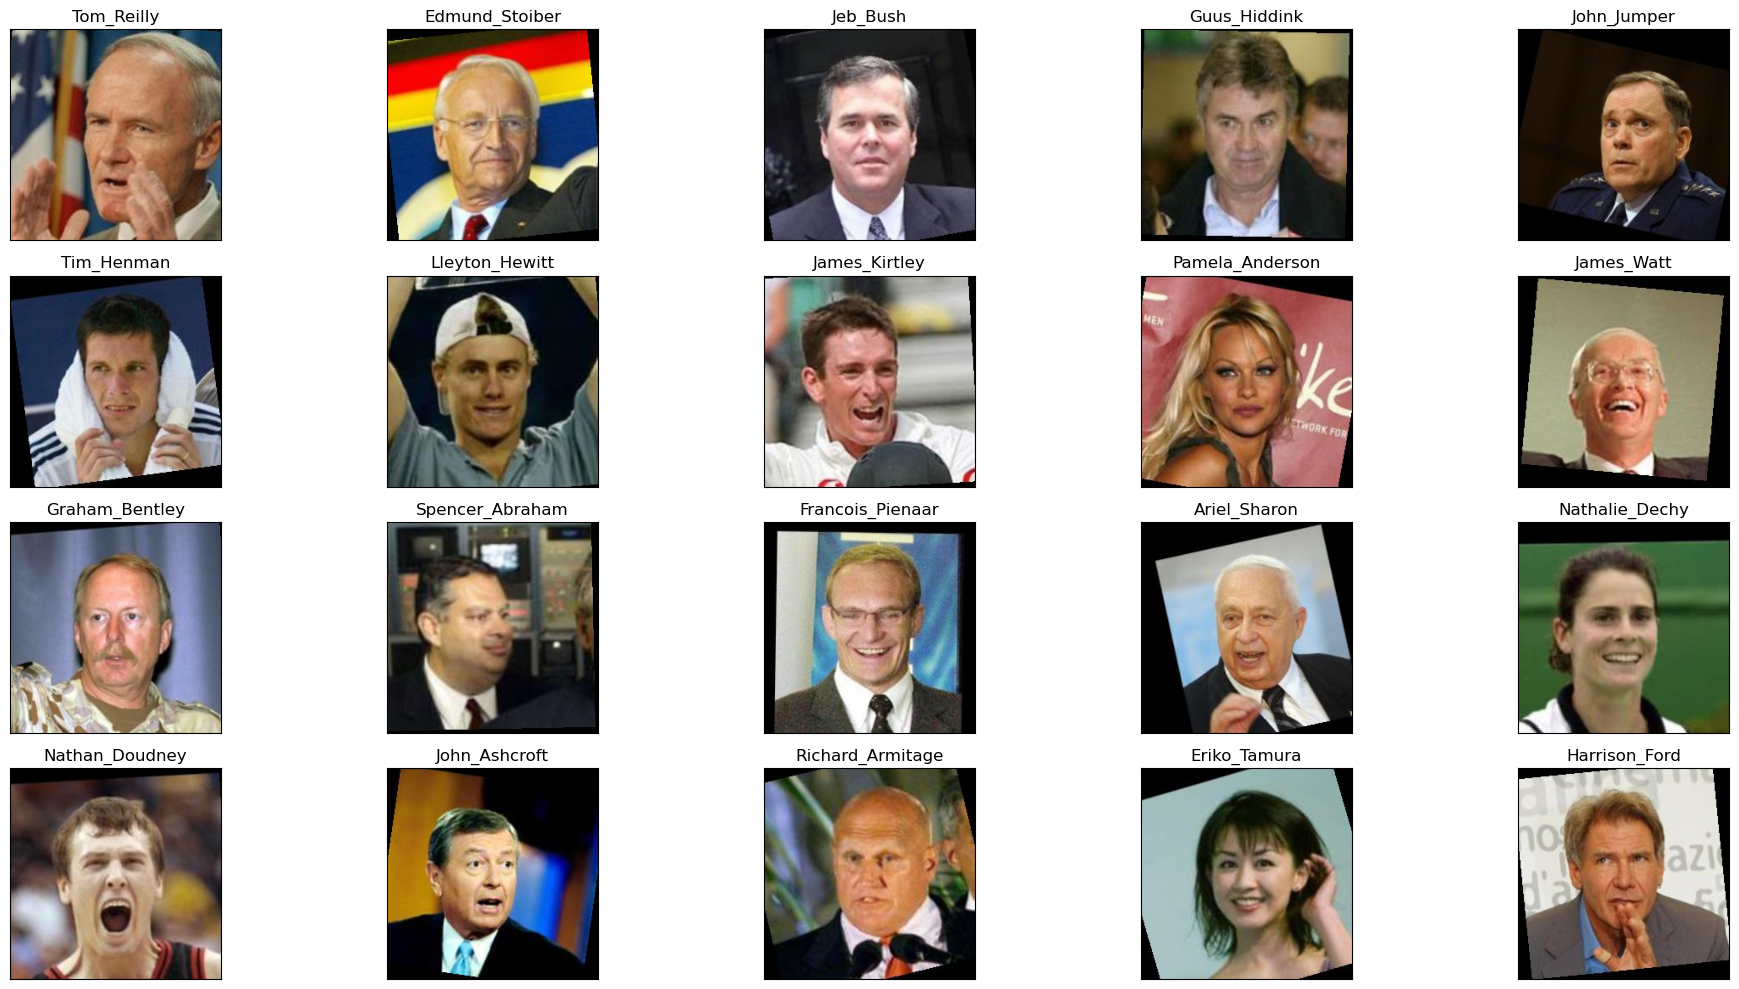

In [4]:
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

The following cell shows the images with some of the background removed.

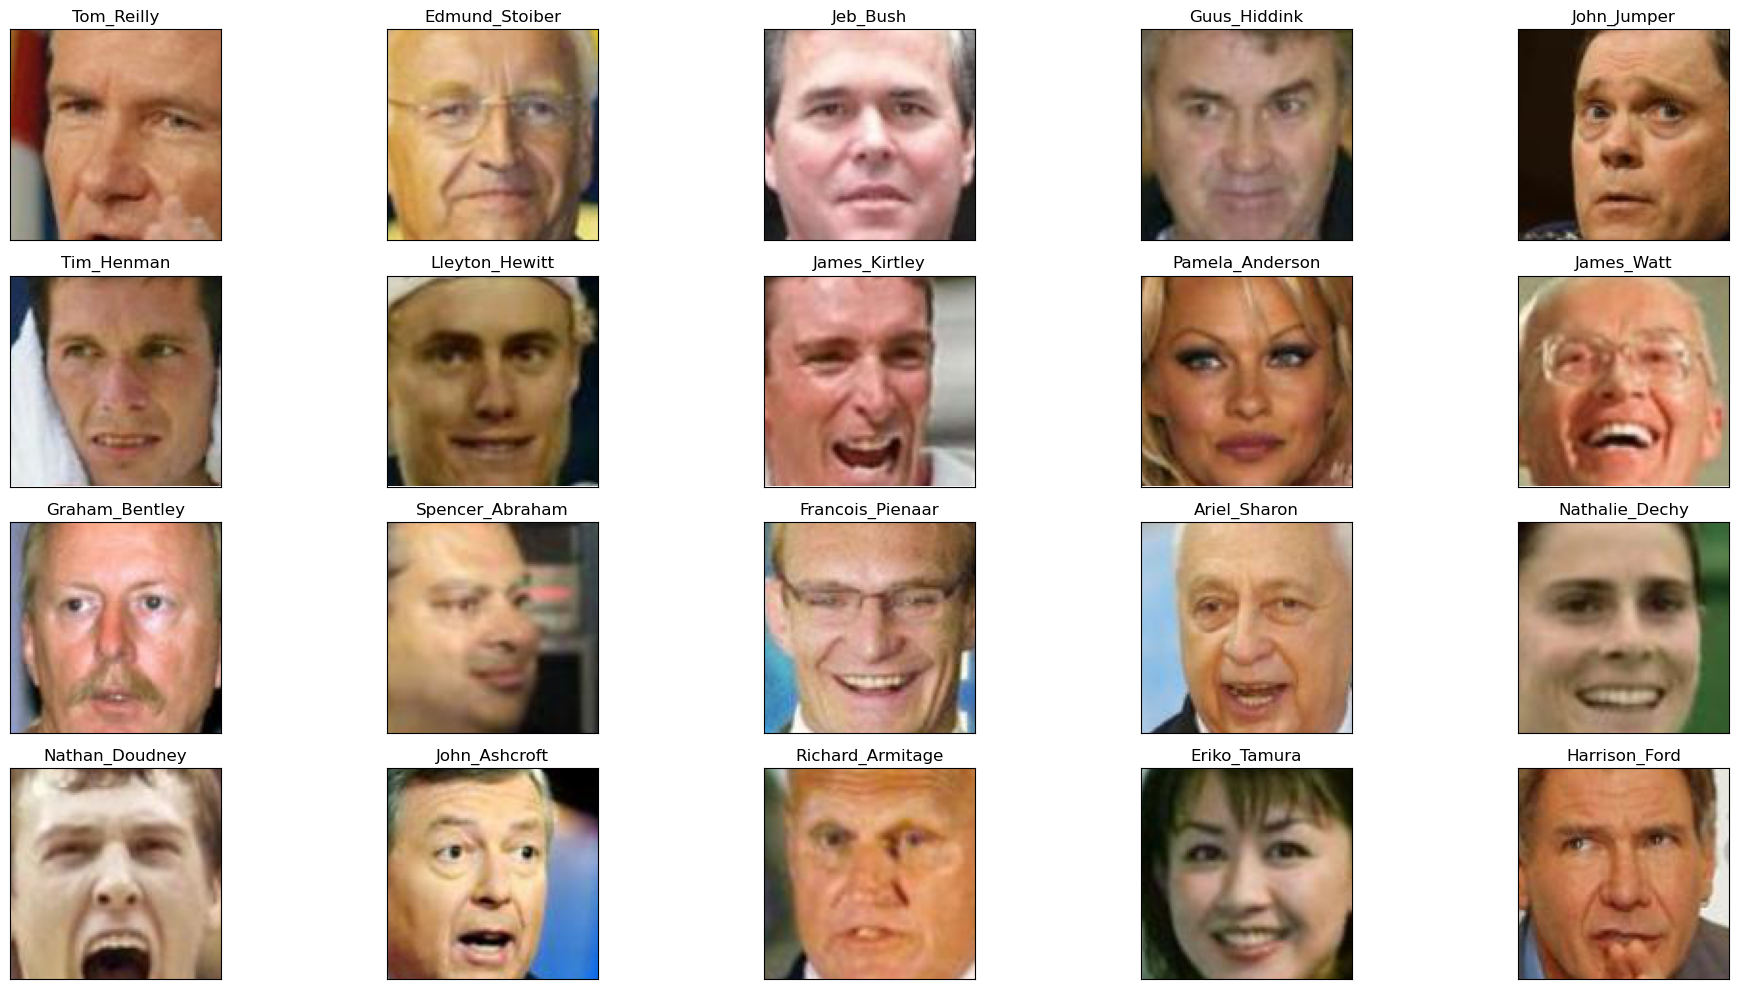

In [5]:
dx=70
dy=70

plt.figure(figsize=(20,10))
for i in range(20):
    idx = sampled_id[i]
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img[dy:-dy,dx:-dx])
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The following function crops the images to 45x45 pixels, which is what we will use in this problem.

In [6]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [7]:
data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

### Create Face Groups

We can now create groups of faces, by selecting the faces having the highest or lowest scores for each of the attributes. Run all the cells in this section to create and plot some face groups.

In [8]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.75 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [9]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

In [10]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).head(36).index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(36).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(36).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(36).index.values
sunglasses_data = data[sunglasses_ids]

mustache_ids = attrs['Mustache'].sort_values(ascending=False).head(36).index.values
mustache_data = data[mustache_ids]

male_ids = attrs['Male'].sort_values(ascending=False).head(36).index.values
male_data = data[male_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(36).index.values
female_data = data[female_ids]

eyeclosed_ids = attrs['Eyes Open'].sort_values(ascending=True).head(36).index.values
eyeclosed_data = data[eyeclosed_ids]

mouthopen_ids = attrs['Mouth Wide Open'].sort_values(ascending=False).head(36).index.values
mouthopen_data = data[mouthopen_ids]

makeup_ids = attrs['Heavy Makeup'].sort_values(ascending=False).head(36).index.values
makeup_data = data[makeup_ids]

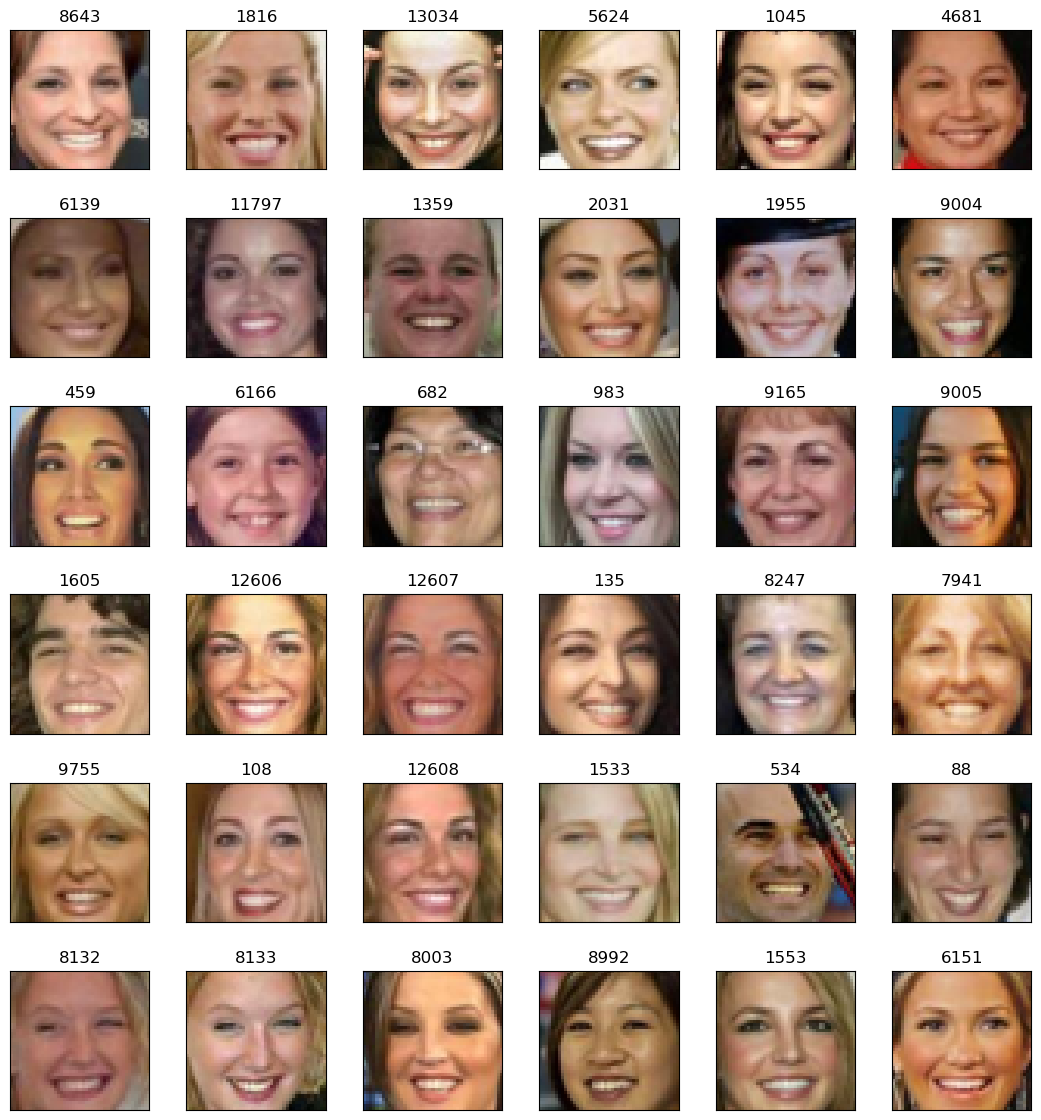

In [11]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=smile_ids)

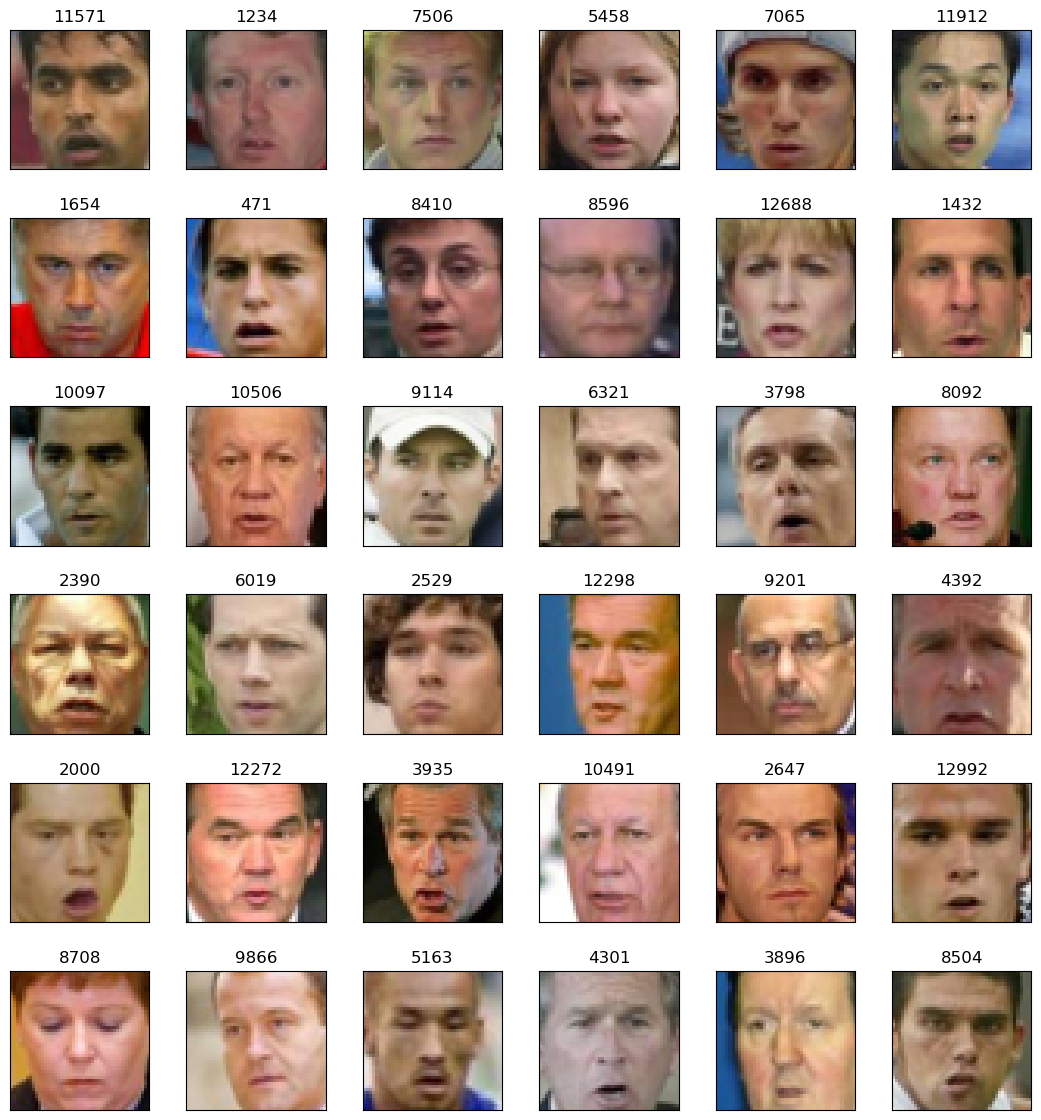

In [12]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=no_smile_ids)

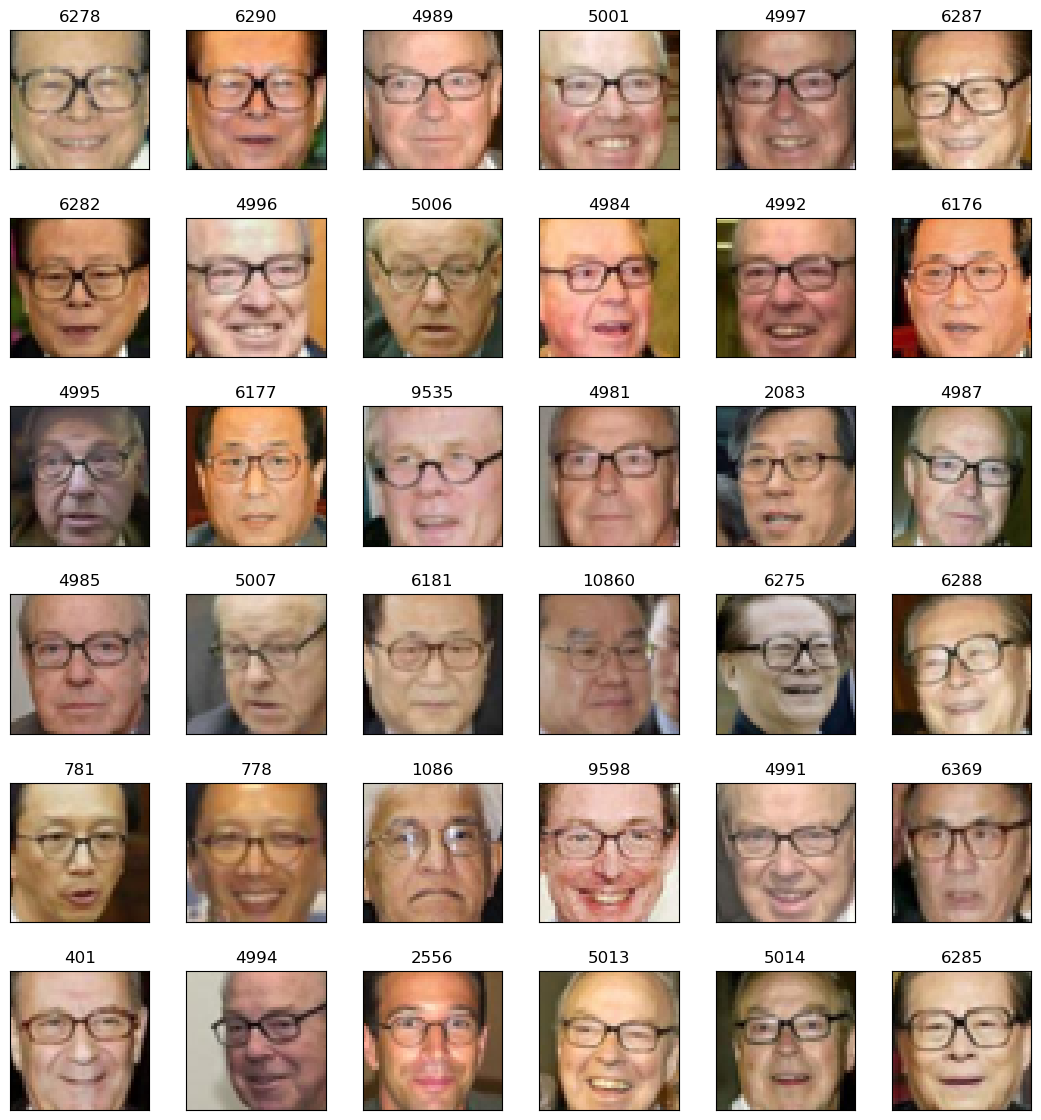

In [13]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeglasses_ids)

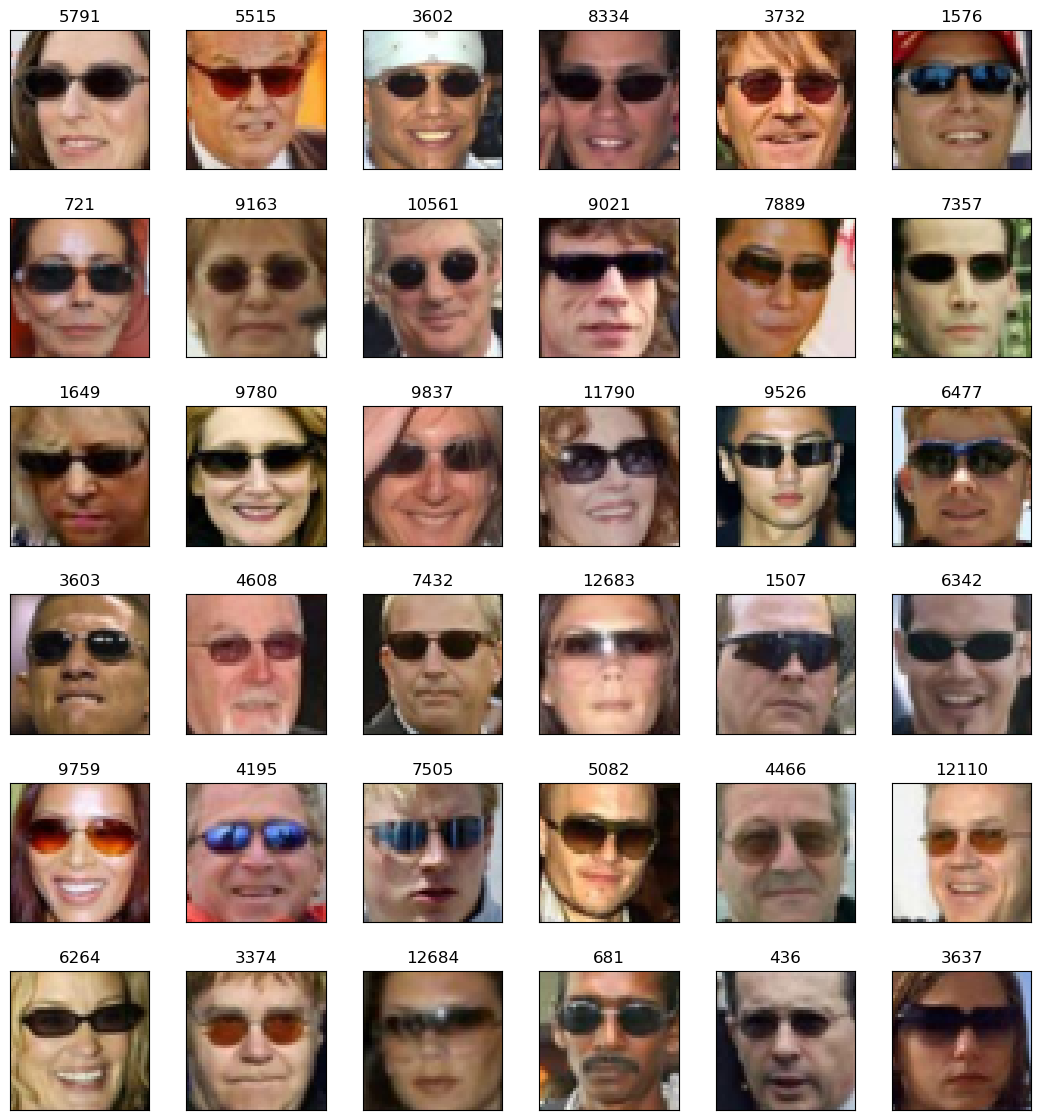

In [14]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=sunglasses_ids)

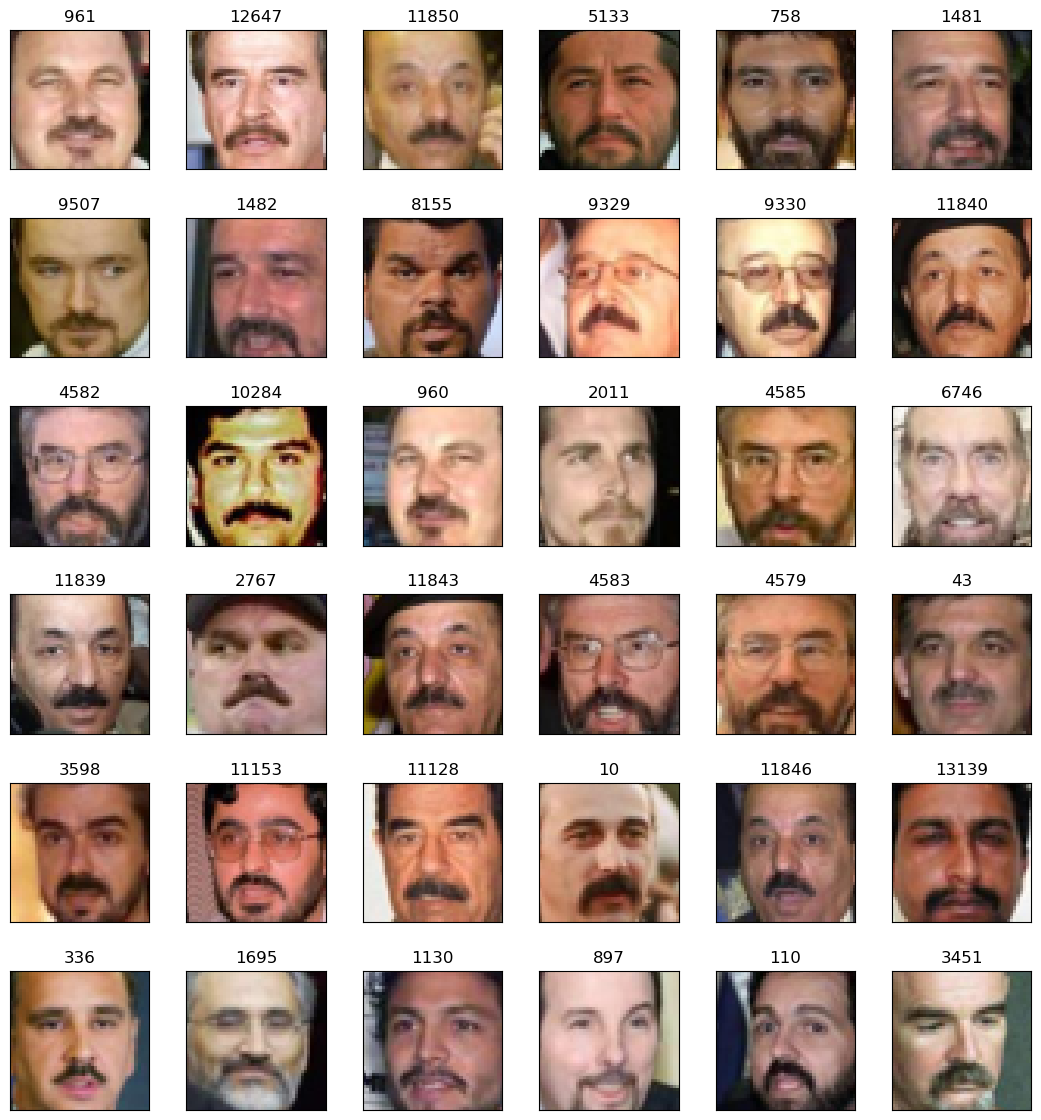

In [15]:
plot_gallery(mustache_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mustache_ids)

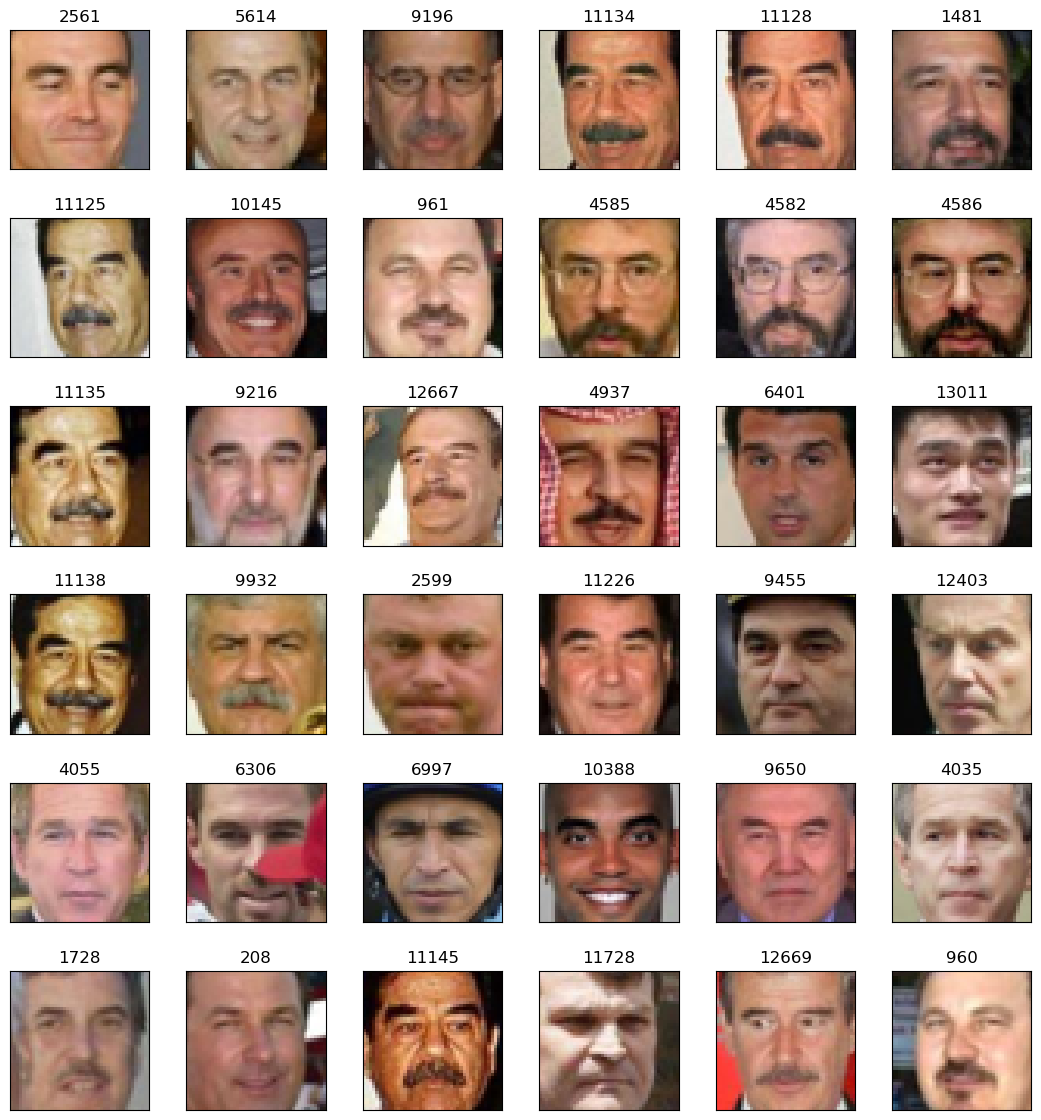

In [16]:
plot_gallery(male_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=male_ids)

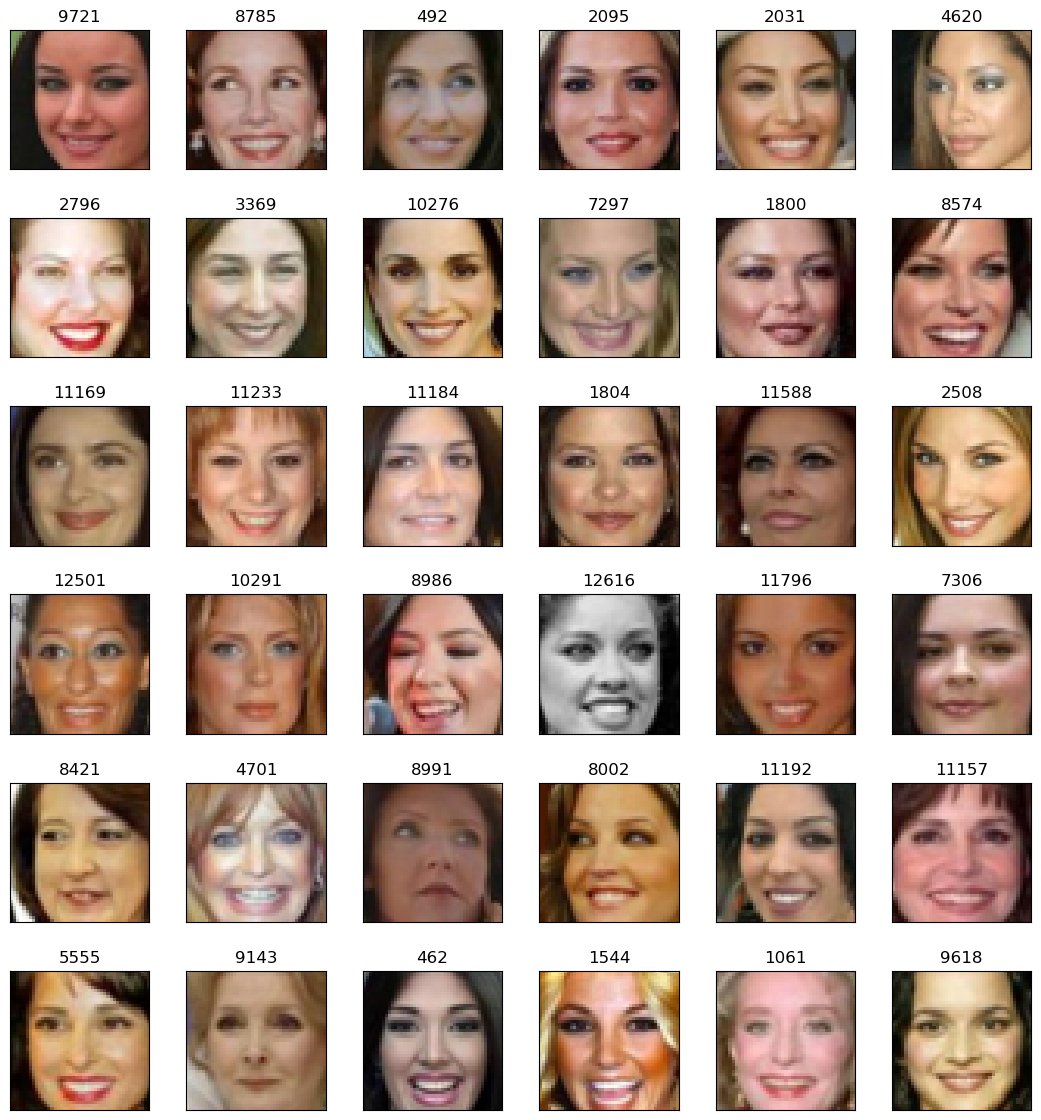

In [17]:
plot_gallery(female_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=female_ids)

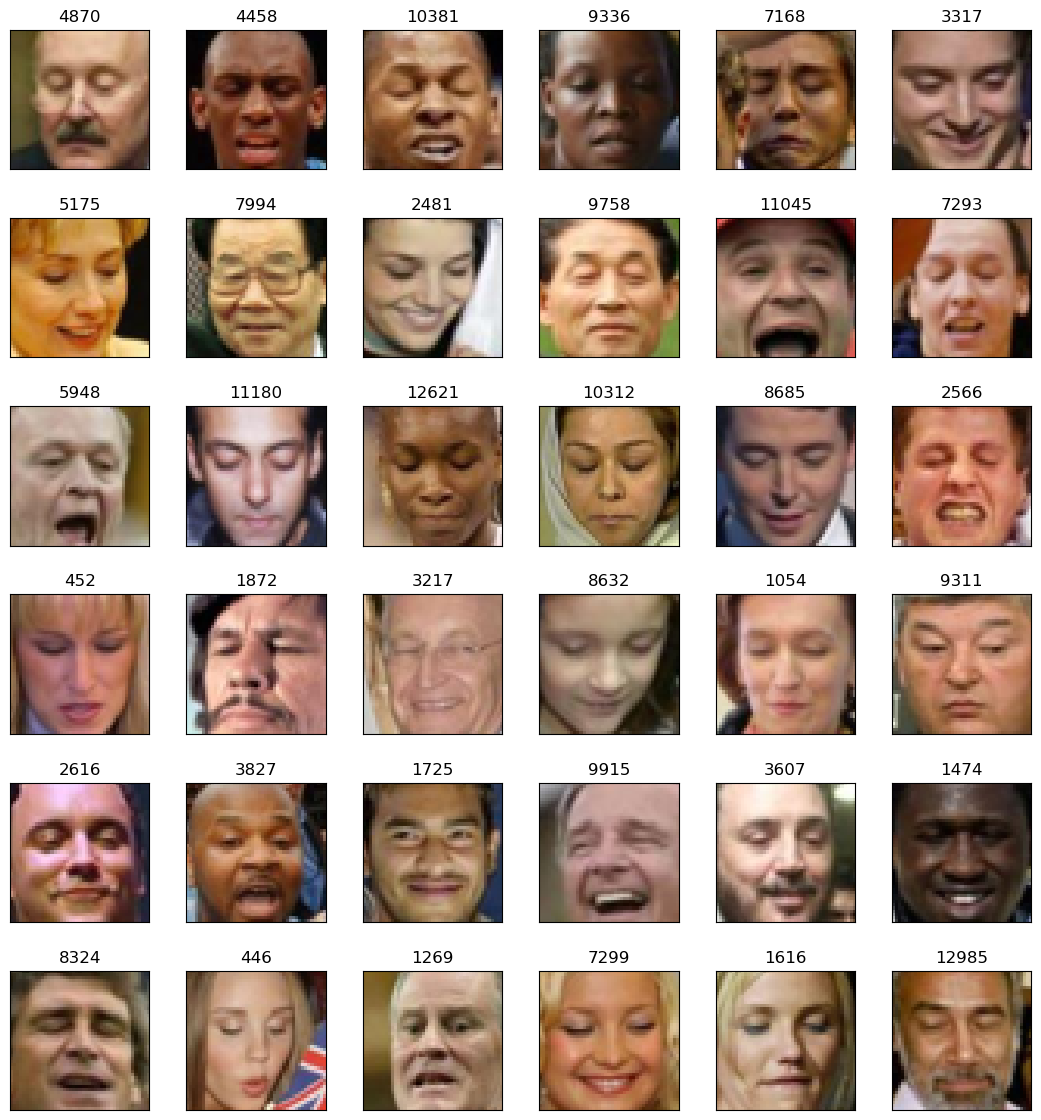

In [18]:
plot_gallery(eyeclosed_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeclosed_ids)

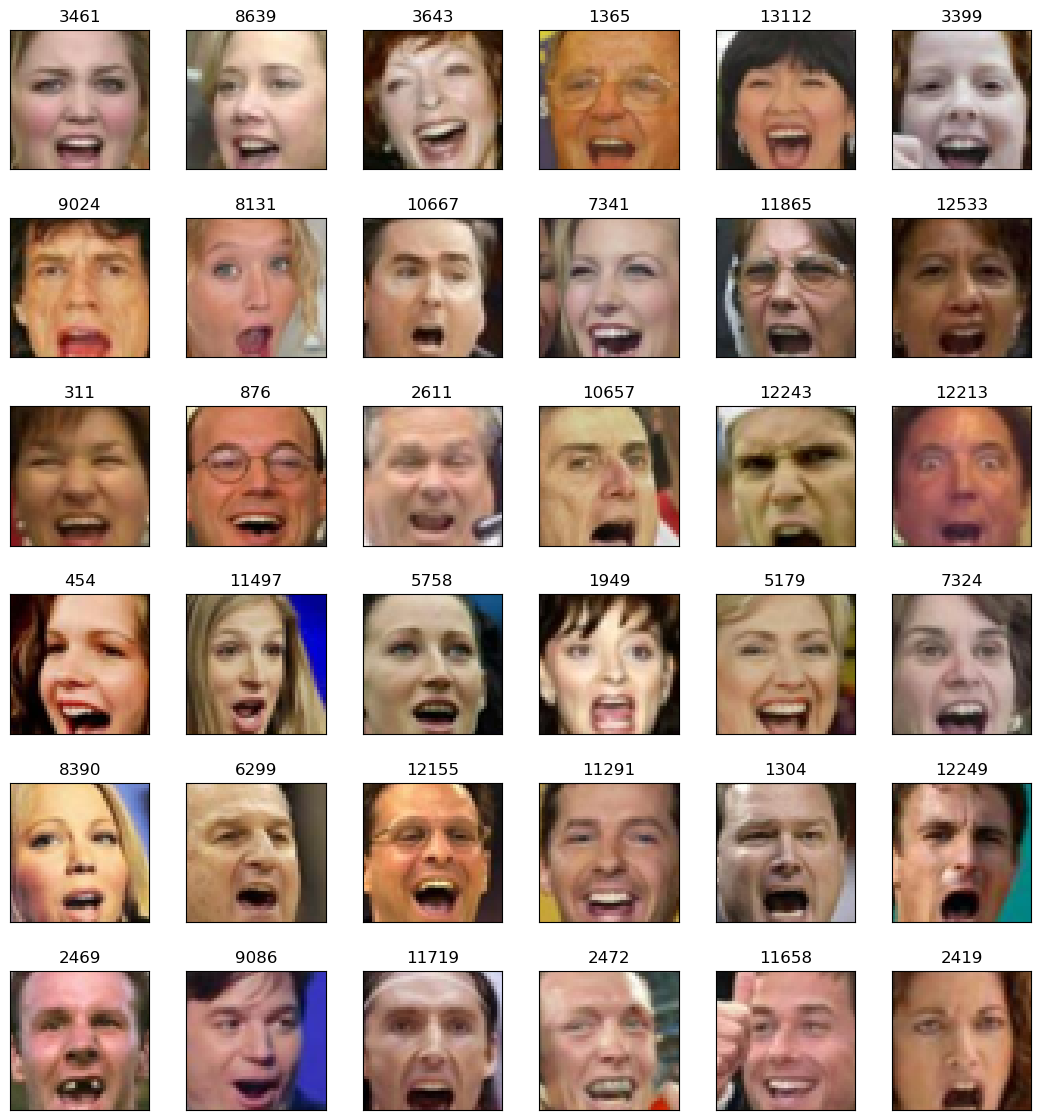

In [19]:
plot_gallery(mouthopen_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mouthopen_ids)

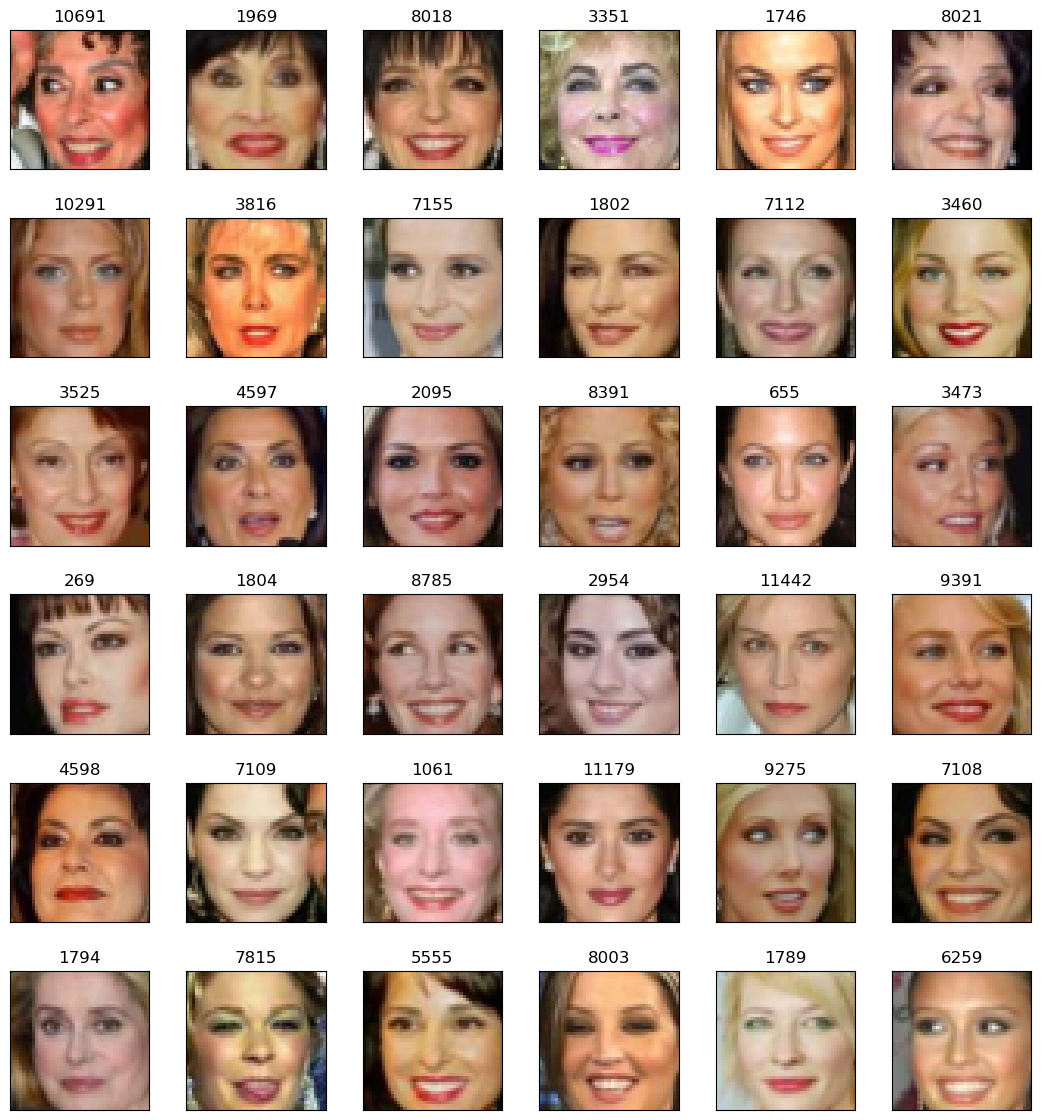

In [20]:
plot_gallery(makeup_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=makeup_ids)

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [21]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [22]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [23]:
input_data = tensorflow.keras.layers.Input(shape=(45, 45, 3))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

2025-10-07 18:33:47.792786: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-10-07 18:33:47.792811: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-10-07 18:33:47.792817: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-10-07 18:33:47.792831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-07 18:33:47.792841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 45, 45, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 41, 41,    │      4,864 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 18, 18,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 9, 9, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 288)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ variational_mean… │
│                     │                   │            │ variational_log_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,056 (461.16 KB)

 Trainable params: 118,056 (461.16 KB)

 Non-trainable params: 0 (0.00 B)

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [24]:
decoder_input = tensorflow.keras.layers.Input(shape=(LATENT_SPACE_SIZE,))
decoder = tensorflow.keras.layers.Reshape((1, 1, 100))(decoder_input)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(16, (5,5), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(3, (6,6), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 64)       │        57,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 32)       │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 20, 20, 16)     │        12,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 45, 45, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,675 (354.20 KB)

 Trainable params: 90,675 (354.20 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [26]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        return 0.5*reconstruction_loss_batch*factor

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [27]:
# Keras 3-safe: use keras.ops everywhere
from keras import ops, layers

# ---- KL term inside the graph (assumes log-variance) ----
class KLLoss(layers.Layer):
    def __init__(self, beta=1.0, batch_size=64, name="kl_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.batch_size = batch_size

    def call(self, inputs):
        mu, logvar = inputs                 # logvar = log(σ^2)
        var = ops.exp(logvar)
        # KL per sample: 0.5 * sum(mu^2 + var - 1 - logvar)
        kl_per_sample = 0.5 * ops.sum(
            ops.square(mu) + var - 1.0 - logvar,
            axis=-1
        )
        # Fixed batch-size normalization
        bs = ops.cast(self.batch_size, mu.dtype)
        kl = self.beta * (ops.sum(kl_per_sample) / bs)
        self.add_loss(kl)
        return inputs  # pass-through

# distribution_variance is LOG-variance
_ = KLLoss(beta=1.0, batch_size=64)([distribution_mean, distribution_variance])

def make_reconstruction_loss_fixed_bs(factor=1.0, batch_size=64):
    def loss(y_true, y_pred):
        se = ops.square(y_true - y_pred)
        per_sample = ops.sum(se, axis=tuple(range(1, ops.ndim(se))))
        bs = ops.cast(batch_size, y_true.dtype)
        return 0.5 * factor * (ops.sum(per_sample) / bs)
    return loss

### 1.1 Deriving the loss function (5 points)

Derive the loss function defined in the cell above from the probability model perspective. You can ignore the scalar `factor` in your derivation. Show your work using either LaTeX or a picture of your written solution.

Hint: Think about how how the total loss is related to the ELBO.

[Your derivation here]

The following three cells train the model. You can just run them. It may take a while to run on your laptop.

In [28]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=365)

In [ ]:
batch_size = 64

autoencoder.compile(
    optimizer="adam",
    loss=make_reconstruction_loss_fixed_bs(factor=1.0, batch_size=64)
)
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45, 45, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 100)            │       118,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 45, 45, 3)      │        90,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,731 (815.36 KB)

 Trainable params: 208,731 (815.36 KB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val))

Epoch 1/50


In [ ]:
# Save your trained model (for later use)

# autoencoder.save("My_Trained_VAE")
# encoder_model.save("My_Trained_encoder")
# decoder_model.save("My_Trained_decoder")

If you experience issues while training the models above or if the process is taking too long, you may also use our pre-trained versions of the VAE, encoder, and decoder, which are available on Canvas.

No points will be taken off if you decide to use the pre-trained models, but we do recommend trying out the training process above. In case you encounter any issues when loading in the models, please post your questions on Ed discussion.

In [ ]:
# Load Pre-trained Model

batch_size = 64
autoencoder = tensorflow.keras.models.load_model("Trained_VAE",compile=False)
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

encoder_model = tensorflow.keras.models.load_model("Trained_encoder",compile=False)
encoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

decoder_model = tensorflow.keras.models.load_model("Trained_decoder",compile=False)
decoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

### 1.2 Reconstructing faces (3 points)

The following cell encodes and reconstructs 16 random faces from the validation set with the trained VAE. Run the cell and comment on the reconstructed faces. (3 points)
* Do the reconstructed faces resemble the original images? How are they similar/different?
* Are there any faces that are reconstructed better or worse than the others? Can you think of why?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
sample_index = random.sample(range(1, len(X_val)), 16)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(X_val[sample_index[4*i+j], :, :, :])
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(np.clip(autoencoder.predict(np.array([X_val[sample_index[4*i+j], :, :, :]]))[0],0,1))
        axs[i, 2*j+1].axis('off')

*Solution.* As long as it makes sense.


### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [ ]:
def LatentSpace_2D(encoder_model, data1, label1, data2, label2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    z = np.concatenate((z1, z2))
    pca = PCA(n_components=2).fit_transform(z)

    n = len(data1)
    plt.plot(pca[:n, 0], pca[:n, 1], ".", label=label1)
    plt.plot(pca[n:, 0], pca[n:, 1], ".", label=label2)
    plt.legend()

In [ ]:
LatentSpace_2D(encoder_model, smile_data, 'Smile', no_smile_data, 'No smile')

In [ ]:
LatentSpace_2D(encoder_model,smile_data,'No sunglasses',sunglasses_data,'Sunglasses')

In [ ]:
LatentSpace_2D(encoder_model,male_data,'Male',female_data,'Female')

*Solution.* While none of the groups are completely separable, they are generally well-separated, which is expected. The contrasting groups are based on visually significant factors, so distinct clusters are anticipated.

In the Male/Female plot, there is more overlap between the groups, indicating a higher number of impostors compared to the other two cases. The Sunglasses plot shows the clearest separation, while the Smile group falls somewhere in between.




[Your markdown here]

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

In [ ]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

In [ ]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)


*Solution.* The morphing process in this function works by gradually blending two images using both shape and pixel transformations. First, the function extracts latent representations (z1 and z2) of both images using an encoder model. Then, for each step in the morphing sequence, a weighted average (alpha) is applied between the two latent vectors to create a new intermediate representation. This intermediate representation is passed through the decoder model to generate the corresponding morphed image. The process is visualized by showing the gradual transition between the two original images as the value of alpha shifts from 0 (first image) to 1 (second image), creating a smooth transformation.




### 1.5 Attribute shift (10 points)

In 1.3, we've seen that faces with the same attributes form clusters in the latent space. In this problem, you will implement a function `AttributeShift` to change one attribute of the faces.

First implement the function `AttributeShift`. (5 points)
1. Calculate the latent space codes for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Calculate the mean latent space code for each group.
3. Get the attribute shifting vector by taking the difference between the two codes.
4. Perform attribute shift by adding the attribute shifting vector to the latent space code of the faces you want to modify.
5. Generate the image using the new latent space codes.

Here is a diagram demonstrating the shift in the latent space. Please note that the two-dimensional latent space is just for demonstration purpose. You should *not* use PCA in this problem. Instead, use the original latent space.
![Diagram_1_5](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Diagram_1_5.png)

Perform attribute shift on at three attributes including smile. Comment on the faces with shifted attributes. (5 points)
* Do the generated faces look like what you expected? If not, can you think of some possible reasons?
* Do the faces with new attributes resemble the original faces? If not, can you think of some possible reasons?
* Which of the attribute shift is more successful? What are some possible reasons?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [ ]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    delta = np.mean(z1, axis=0) - np.mean(z2, axis=0)
    pic_output = decoder_model.predict(z2 + delta)
    return pic_output

In [ ]:
pic_output = AttributeShift(encoder_model,decoder_model,smile_data,no_smile_data)
PlotAttributeShift(no_smile_data,pic_output)

*Solution.* As long as it makes sense.

### 1.6 Generating new faces (3 points)

Variational autoencoders can be used to generate new data; this is why they are generative models. We can sample new data points from the distribution in latent space and reconstruct new, fake faces based on them.

To draw a sample close to an existing sample in the latent space, we can add a scaled random sample from the normal distribution to the latent space code of an existing sample. The scalar, which we call the `noise_level` is a parameter that we can tune.

Run `GenerateFaces` with three different values of `noise_level` and comment on the generated faces. (3 points)
* Do the generated images look like faces?
* What happens when the new samples diverge more from the existing samples? What is a possible reason?

In [ ]:
number_of_images = 15
def GenerateFaces(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level*np.random.normal(size=(15,LATENT_SPACE_SIZE))+encoder_model.predict(data[sample_index])
    generated_image = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15,10))
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.imshow(np.clip(generated_image[i, :,:,:],0,1))
        ax.axis('off')

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.1)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.5)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,1)

In [ ]:
# Your markdown here

*Solution.* As long as it makes sense.

### Optional: Changing the loss function (2 points extra credit)

The variable `factor` is a parameter of the loss function. In this optional problem, you will play with it and think about its effect on the performance of VAE.

Retrain the model with a smaller factor. Repeat 1.2, 1.6 (using `noise_level` = 1) and latent space visualization. Comment on how the reconstruction results, generated new faces and latent space distributions change. (2 points)
* Which model reconstructs the faces better?
* Do the generated faces look different?
* How do the latent variable distributions differ?
* Do the differences make sense? Can you explain what you observed?

In [ ]:
# Your code here

*Solution.* As long as it makes sense.

[Your markdown here]

$\newcommand{\reals}{{\mathbb R}}
\newcommand{\indp}{\perp\kern-4pt\perp}
\newcommand{\given}{\,|\,}
$

## Problem 2: Are you Schur? (10 points)

The graphical lasso is based on conditional independence properties
of Gaussian distributions. This problem asks you to reason about the graphs
underlying a multivariate Gaussian.

Let $X = (Y,Z) \in \reals^6 \sim N(0, \Sigma)$ be a random
Gaussian vector where $Y = (Y_1,Y_2) \in\reals^2$ and
$Z = (Z_1,Z_2,Z_3,Z_4) \in\reals^4$, with
$\Sigma^{-1} = \Omega =  \begin{pmatrix}
A & B \\
B^T & C
\end{pmatrix}
$
where
$$
A = \begin{pmatrix} 2 & 0 \\ 0 & 2\end{pmatrix} \qquad
B = \begin{pmatrix} 1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} \\[1pt]
                     -1 & \frac{1}{2} & -\frac{1}{3} & \frac{1}{4}
\end{pmatrix} \qquad
C = \begin{pmatrix}
2 & \frac{1}{2} & 0 & 0 \\
\frac{1}{2} & 2 & 0 & 0 \\
0 & 0 & 2 & \frac{1}{2} \\
0 & 0 & \frac{1}{2} & 2
\end{pmatrix}.
$$

### Problem 2.1

Draw the undirected graph of $X$, arranging the vertices in a hexagon. Explain your answer.

<br>

### Problem 2.2

Draw the undirected graph of $Z$, arranging the vertices in a square.  Explain your answer.
Hint:  The
[Schur complement](https://en.wikipedia.org/wiki/Schur_complement)
$ S= C  - B^T A^{-1} B$ has the property that

\begin{equation*}
\begin{pmatrix}
A & B \\
B^T & C
\end{pmatrix}^{-1}
\;=\;
\begin{pmatrix}
A^{-1} + A^{-1} B S^{-1} B ^T A^{-1} & - A^{-1} B S^{-1}  \\
- S^{-1} B^T A^{-1} & S^{-1}
\end{pmatrix}
\end{equation*}


<br>

### Problem 2.3

Write down the set of all conditional independence relations on the undirected graph of $X$.

## Problem 3: Taking stock (15 points)

A joint distribution of data has a natural graph associated with it. When the distribution is multivariate normal, this graph is encoded in the pattern of zeros and non-zeros in the inverse of the covariance matrix, also known as the "precision matrix."

In class we demonstrated the graphical lasso for estimating the graph on ETF data.
In this problem you will construct two different "portolios" of stocks,
and run the graphical lasso to estimate a graph, commenting on your results.

All of the code you might need for this is contained in the demo.


### Downloading data

As demonstrated in class, you will run on equities data downloaded from Yahoo finance.
Your job is to construct two "portfolios" of stocks, each of which has some kind of organization to it. For example, in one portfolio you might have 5 energy stocks, 5 tech stocks, 5 consumer staples stocks, and 5 ETF stocks. Each portfolio should have at least 20 stocks.

The page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies has GICS sectors, which you may find useful for the glasso problem.

To download the data, follow the procedure outlined below (and discussed briefly in class):

  * Search on a ticker symbol, like EZA, using [https://finance.yahoo.com/quote/EZA/history?p=EZA](https://finance.yahoo.com/quote/EZA/history?p=EZA)
  * Select the range of the query, the frequency (daily, weekly, or monthly) and then issue the query. This will give you results like this:
  
 ![ezh](https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/graphs/ezh.png)

  * Next, hover over the Download link, and grab the URL. In this case it gives
  https://query1.finance.yahoo.com/v7/finance/download/EZA?period1=1044576000&period2=1648080000&interval=1d&events=history&includeAdjustedClose=true
  
  * Then, you can use this same URL, but swap in different ticker symbols, to get the corresponding data for range of companies or funds.  


### Analyzing  your portfolios

Your task is to analyze each porfolio using the graphical lasso, and comment on your findings.
Here are the types of questions you should address:

* How did you choose the portolio? How did you choose the date range and frequency (daily, weekly, etc.)? Remember, each of the portfolios must contain at least 20 stocks, and be organized in some reasonable way.

* Display the graph obtained with the graphical lasso, using networkx. How did you choose the regularization level? Does the structure of the graph make sense? Is it sensitive to the choice of regularization level? Is this the structure you expected to see when you designed the portfolio? Why or why not?

* What are some of the conditional independence assumptions implied by the graph? Are some parts of the graph more densely connected than others? Why?


